# 4.4 模型选择、欠拟合和过拟合

过拟合（overfitting）：将模型在训练数据上拟合得比在潜在分布中更接近的现象

正则化（regularization）：用于对抗过拟合的技术称为

## 4.4.1 训练误差和泛化误差
训练误差（training error）是指，我们的模型在训练数据集上计算得到的误差。

泛化误差（generalization error）是指，当我们将模型应用在同样从原始样本的分布中抽取的无限多的数据样本时，我们模型误差的期望。

独立同分布假设，这意味着对数据进行采样的过程没有进行“记忆”。

### 影响模型泛化的因素：
1. 可调整参数的数量。当可调整参数的数量（有时称为*自由度*）很大时，模型往往更容易过拟合。
1. 参数采用的值。当权重的取值范围较大时，模型可能更容易过拟合。
1. 训练样本的数量。即使你的模型很简单，也很容易过拟合只包含一两个样本的数据集。而过拟合一个有数百万个样本的数据集则需要一个极其灵活的模型。

## 4.4.2 模型选择

### 验证集

### K折交叉验证
原始训练数据被分成K个不重叠的子集。然后执行K次模型训练和验证，每次在K−1个子集上进行训练，并在剩余的一个子集（在该轮中没有用于训练的子集）上进行验证。最后，通过对K次实验的结果取平均来估计训练和验证误差。

### 欠拟合
训练误差和验证误差都很严重，但它们之间仅有一点差距。如果模型不能降低训练误差，这可能意味着我们的模型过于简单（即表达能力不足），无法捕获我们试图学习的模式

### 过拟合
练误差明显低于验证误差时要小心

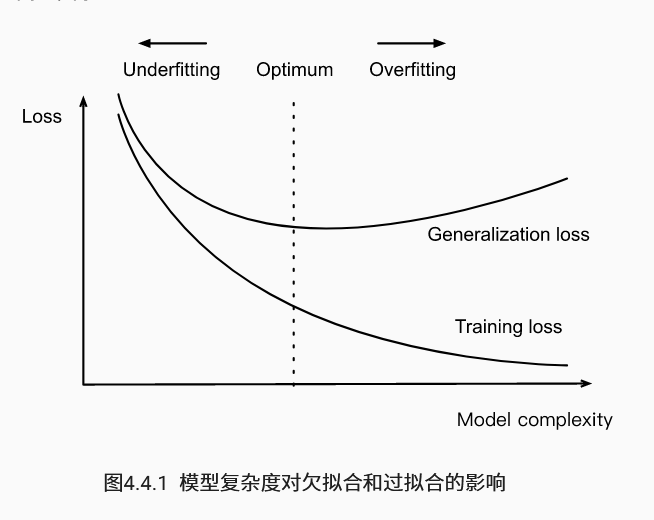

### 数据集大小
训练数据集中的样本越少，我们就越有可能（且更严重地）遇到过拟合。

随着训练数据量的增加，泛化误差通常会减小。

此外，一般来说，更多的数据不会有什么坏处。

## 4.4.4 多项式回归

In [2]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据集
给定$x$，我们将[**使用以下三阶多项式来生成训练和测试数据的标签：**]

(**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**)

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。

In [ ]:
### ?np.power-200,20

In [3]:
# 训练集和测试集各生成100个样本
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
# poly_features.shape((200,20))
# features.shape(200,1)
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)


In [10]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    d2l.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]


(tensor([[0.1015],
         [0.8646]]),
 tensor([[1.0000e+00, 1.0155e-01, 5.1561e-03, 1.7453e-04, 4.4309e-06, 8.9990e-08,
          1.5231e-09, 2.2095e-11, 2.8047e-13, 3.1646e-15, 3.2136e-17, 2.9667e-19,
          2.5106e-21, 1.9611e-23, 1.4225e-25, 9.6302e-28, 6.1121e-30, 3.6510e-32,
          2.0598e-34, 1.1009e-36],
         [1.0000e+00, 8.6458e-01, 3.7375e-01, 1.0771e-01, 2.3281e-02, 4.0257e-03,
          5.8009e-04, 7.1647e-05, 7.7431e-06, 7.4383e-07, 6.4310e-08, 5.0547e-09,
          3.6418e-10, 2.4220e-11, 1.4957e-12, 8.6211e-14, 4.6585e-15, 2.3692e-16,
          1.1380e-17, 5.1783e-19]]),
 tensor([5.0327, 5.1856]))

### 对模型进行训练和测试

In [13]:
# 一个函数来评估模型在给定数据集上的损失
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]


In [14]:
# 定义训练函数
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 三阶多项式函数拟合(正态)

weight: [[ 5.000809   1.220102  -3.4085546  5.518066 ]]


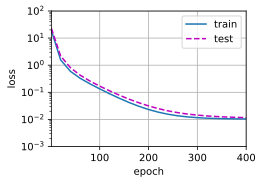

In [15]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])


### 线性函数拟合(欠拟合)

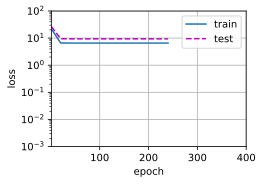

In [ ]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])


### 高阶多项式函数拟合(过拟合)

In [ ]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)


## 4.4.5 小结

* 由于不能基于训练误差来估计泛化误差，因此简单地最小化训练误差并不一定意味着泛化误差的减小。机器学习模型需要注意防止过拟合，来使得泛化误差最小。
* 验证集可以用于模型选择，但不能过于随意地使用它。
* 欠拟合是指模型无法继续减少训练误差。过拟合是指训练误差远小于验证误差。
* 我们应该选择一个复杂度适当的模型，避免使用数量不足的训练样本。

## 4.4.6 练习

1. 你能准确地解出这个多项式回归问题吗？提示：使用线性代数。
1. 考虑多项式的模型选择：
    1. 绘制训练损失与模型复杂度（多项式的阶数）的关系图。你观察到了什么？需要多少阶的多项式才能将训练损失减少到0?
    1. 在这种情况下绘制测试的损失图。
    1. 生成同样的图，作为数据量的函数。
1. 如果你不对多项式特征$x^i$进行标准化($1/i!$)，会发生什么事情？你能用其他方法解决这个问题吗？
1. 你能期待看到泛化误差为零吗？